# Federal Prisons next to golf courses

Gets all US Federal Prisons and their point locations from wikipedia and then searches if they are next to (i.e. within 2km of) a golf course. 2km was chosen because that's a 10 minute golf buggy ride away. It then plots this data on a map of the contiguous United States

In [1]:
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point

import requests
from bs4 import BeautifulSoup

import geoplot as gplt
import geoplot.crs as gcrs
from matplotlib.pyplot import savefig

In [2]:
def prison_data_getter():
    '''gets all the data about federal prisons on wikipedia and then scrapes their location
    saving this data as a csv to enable manual addition of the ones that, for whatever reason
    don't have proper location data on wikipedia.
    '''
    
    url = "https://en.wikipedia.org/wiki/List_of_United_States_federal_prisons"
    wiki = 'https://en.wikipedia.org'
    api = 'https://en.wikipedia.org/w/api.php'

    res = requests.get(url)
    soup = BeautifulSoup(res.text)

    tables = soup.find_all('table')[:4] # the first 4 tables on the page are active Federal Prisons

    prisons = []
    for table in tables:
        prisons += [{'name': p['title'],
                     'link':wiki+p['href']}
                     for p in table.find_all('a')]
    print(prisons[:5])

    for prison in prisons:
        params = {
            "action": "query",
            "format": "json",
            "prop": "coordinates",
            "titles": prison['name'],
            "formatversion": "2"
        }

        r = requests.get(api, params=params)
        prison_data = r.json()['query']['pages'][0]

        if 'coordinates' in prison_data.keys():
            prison['lat'] = prison_data['coordinates'][0]['lat']
            prison['lon'] = prison_data['coordinates'][0]['lon']

    df = pd.DataFrame(prisons).set_index('name')

    df.to_csv('prisons.csv')
    
def prison_geojson_maker():
    '''turns the csv created above into a gsojson with the locations saved as points
    '''
    df = pd.read_csv('prisons.csv').set_index('name')
    gdf = gpd.GeoDataFrame(df,
        crs={'init': 'epsg:4326'},
        geometry=gpd.points_from_xy(df.lon, df.lat))

    gdf.to_file("../data/federal_prisons.geojson", driver='GeoJSON')
    
    
# To generate the database uncomment the below lines. After running the first line you 
# need to open the csv file and manually add the lat and lon 4 or 5 prisons that for
# whatever reasons don't download properly, but they're easily gettable from google 


# prison_data_getter()
#prison_geojson_maker()


The above cell needs to be modified and then run if regathering data – e.g. if the USA opens or closes another Federal Prison or if auditing the data in the database

In [3]:
prisons = gpd.read_file("../data/federal_prisons.geojson").set_index("name")

In [4]:
def golf_checker(prison):
    overpass_url = "https://lz4.overpass-api.de/api/interpreter"

    radius = '2000' # 2 kilometres
    lat = str(prison.lat)
    lon = str(prison.lon)

    search = ','.join([radius,lat,lon])

    overpass_query = '''
    [out:json];
    (
      // query part for: “leisure=golf_course”
      node["leisure"="golf_course"](around:'''+search+''');
      way["leisure"="golf_course"](around:'''+search+''');
      relation["leisure"="golf_course"](around:'''+search+''');
    );
    // print results
    out body;
    >;
    out skel qt;
    '''
    response = requests.get(overpass_url, 
                        params={'data': overpass_query})
    
    golf_courses = j =response.json()['elements']

    if len(golf_courses) > 0:
        return golf_courses[0]['id']
    else:
        return None

def is_club(prison):
    if pd.isnull(prison['club OSM ID']):
        return False
    else:
        return True
    
    
'''uncomment the two below lines to then scrape OSM to find if there are any golf
courses within a 2 km radius of the prison. If there is, it saves the OSM ID to 
the frame, and then makes a new column with a boolean of if there is a golf club 
or now (overkill but makes plotting easier)
'''
prisons['club OSM ID'] = prisons.apply(golf_checker, axis=1)
prisons['golf club'] = prisons.apply(is_club, axis=1)

prisons_with_golf_clubs = prisons[prisons['golf club']==True]

'''Removes prisons next to the same golf course as multiple prisons are
on the same site, but we don't need to be so specific for this project
'''
prisons_with_golf_clubs.drop_duplicates(subset=['club OSM ID'], inplace=True)
prisons.to_file("../data/federal_prisons.geojson", driver='GeoJSON')

/Users/allisom1/anaconda3/envs/mapenv/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
world_map = gpd.read_file('../basemaps/ne_10m_admin_1_states_provinces_lakes.shp')
us_states = world_map.query('admin in ["United States of America"]').set_index('name')
us_states.drop(['Alaska','Hawaii'],inplace=True)


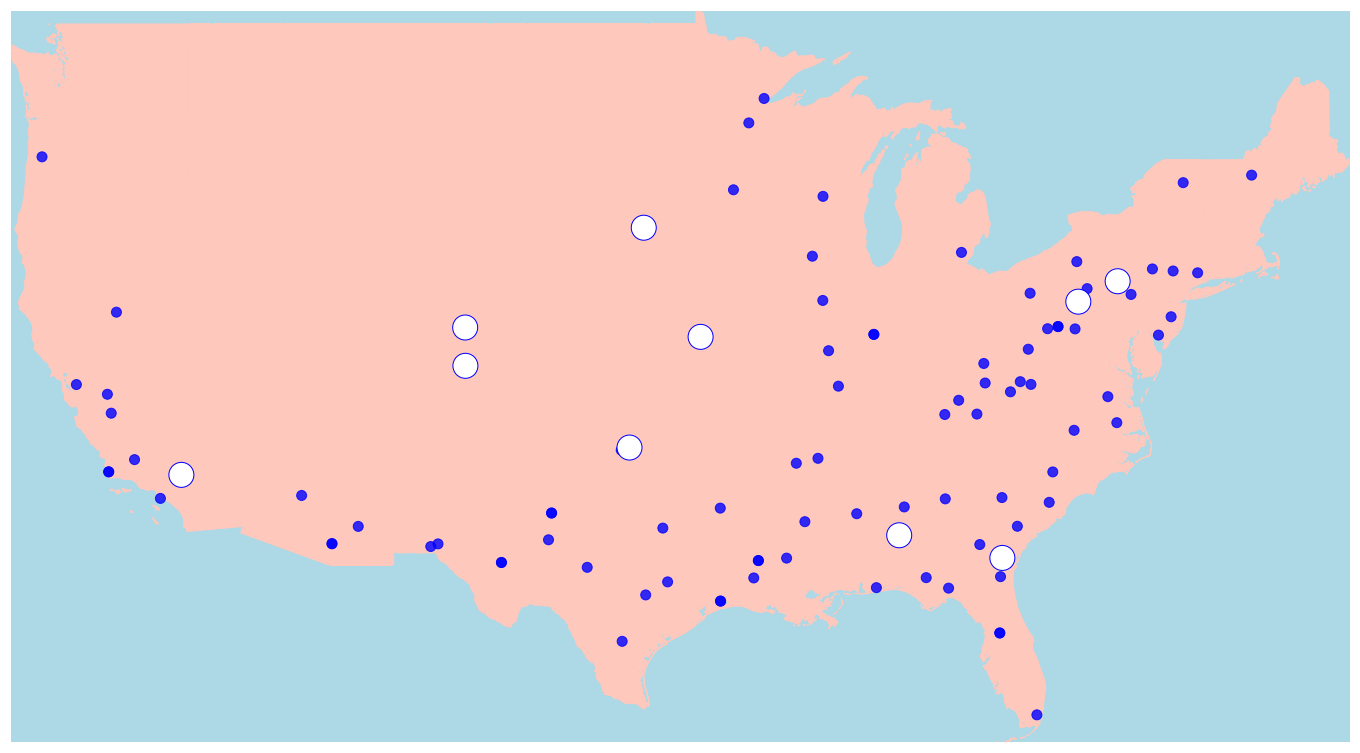

In [6]:
extent = us_states.total_bounds

ax = gplt.polyplot(us_states,
                   figsize=(24, 24),
                   projection=gcrs.WebMercator(),
                   linewidth=1,
                   facecolor='#FFC8BD',
                   edgecolor='#FFC8BD',
                   zorder=1,
                  )

gplt.pointplot(prisons_with_golf_clubs,
               ax=ax,
               color='white',
               edgecolors ='blue',
               projection=gcrs.WebMercator(),
               s=25,
               zorder=10)

gplt.pointplot(prisons,
               ax=ax,
               color='blue',
               projection=gcrs.WebMercator(),
               marker="o",
               s=10,
               alpha=0.8,
               zorder=2,
               extent=extent)

ax.patch.set_facecolor('lightblue')
savefig('../output/federal_prison_golfcourses.png', facecolor='lightblue')

In [7]:
prisons_with_golf_clubs

,link,lat,lon,club OSM ID,golf club,geometry
name,,,,,,
ADX Florence,https://en.wikipedia.org/wiki/ADX_Florence,38.356300,-105.094820,7.858017e+09,True,POINT (-105.09482 38.35630)
"United States Penitentiary, Leavenworth",https://en.wikipedia.org/wiki/United_States_Pe...,39.330000,-94.936389,4.528844e+08,True,POINT (-94.93639 39.33000)
"United States Penitentiary, Victorville",https://en.wikipedia.org/wiki/United_States_Pe...,34.569500,-117.362500,3.056512e+08,True,POINT (-117.36250 34.56950)
"Federal Correctional Institution, Allenwood Low",https://en.wikipedia.org/wiki/Federal_Correcti...,41.163611,-76.923056,3.903564e+07,True,POINT (-76.92306 41.16361)
"Federal Correctional Institution, El Reno",https://en.wikipedia.org/wiki/Federal_Correcti...,35.534722,-98.007222,5.843216e+08,True,POINT (-98.00722 35.53472)
"Federal Correctional Institution, Englewood",https://en.wikipedia.org/wiki/Federal_Correcti...,39.641667,-105.105278,3.697235e+07,True,POINT (-105.10528 39.64167)
"Federal Correctional Institution, Jesup",https://en.wikipedia.org/wiki/Federal_Correcti...,31.563333,-81.902778,3.149890e+07,True,POINT (-81.90278 31.56333)
"Federal Correctional Institution, Loretto",https://en.wikipedia.org/wiki/Federal_Correcti...,40.496000,-78.622000,4.692223e+08,True,POINT (-78.62200 40.49600)
"Federal Prison Camp, Montgomery",https://en.wikipedia.org/wiki/Federal_Prison_C...,32.393000,-86.358500,3.558267e+08,True,POINT (-86.35850 32.39300)
